In [38]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D

In [4]:
class Stock:
    '''
    Event study for each stock index
    '''
    
    def __init__(self, file, event_window = (-5, 5), estimation_window = 200):
        '''
        file - path file saving the info of stock index
        event_date - date occurence an event
        '''
        self.data = pd.read_csv(file)
        self.event_window = event_window
        self.estimation_window = estimation_window
        self.index = Path(file).stem
        if len(self.data)!=0:
            self.data['Date'] = Stock.convert2date(self.data['Date'])
            self.data['joined date'] = Stock.convert2date(self.data['joined date'])
            self.data['Stock'] = Stock.convert2float(self.data['Stock'])
            self.data['Market'] = Stock.convert2float(self.data['Market'])
            self.event_date = self.data.loc[0, 'joined date']
        else:
            self.event_date = 'Unkown'
        
    
    def valid_data(self):
        '''
        Valid the data with the setting option
        '''
        if len(self.data) < self.event_window[1] - self.event_window[0] + self.estimation_window:
            return False
        if self.event_date.weekday()==5:
            self.event_date = self.event_date + timedelta(days=2)
        elif self.event_date.weekday()==6:
            self.event_date = self.event_date + timedelta(days=1)
        # check data with event_window
        event_index = self.data[self.data['Date'] == self.event_date].index
        if len(event_index)==0:
            self.data['distance'] = self.data['Date'] - self.data['joined date']
            max_distance = self.data['distance'].max()
            if max_distance.days<=0:
                return False
            else:                
                self.data['distance'] = self.data['distance'].abs()
                event_index = self.data['distance'].idxmin()           
        else:
            event_index = event_index[0]
        right_event_window_index = event_index + self.event_window[1]
        if right_event_window_index not in self.data.index:
            return False
        # check data with estimation_window
        left_estimation_window_index = event_index - self.estimation_window + self.event_window[0]
        if left_estimation_window_index not in self.data.index:
            return False
        return True
    
    def get_selected_data(self):
        '''
        Select data fitting event_window and estimation window for the next analysis
        '''
        if len(self.data) < self.event_window[1] - self.event_window[0] + self.estimation_window:
            return (False, 'The data range does not fit the estimation period and event window')
        if self.event_date.weekday()==5:
            self.event_date = self.event_date + timedelta(days=2)
        elif self.event_date.weekday()==6:
            self.event_date = self.event_date + timedelta(days=1)
        # check data with event_window
        event_index = self.data[self.data['Date'] == self.event_date].index
        if len(event_index)==0:
            # Tính ngày gần nhất với ngày gia nhập
            self.data['distance'] = self.data['Date'] - self.data['joined date']
            max_distance = self.data['distance'].max()
            if max_distance.days<=0:
                return (False, 'All the data prior to the event data')
            else:                
                self.data['distance'] = self.data['distance'].abs()
                event_index = self.data['distance'].idxmin()
        else:
            event_index = event_index[0]
        right_event_window_index = event_index + self.event_window[1]
        if right_event_window_index not in self.data.index:
            return (False, 'The event window data is out of data range.')
        # check data with estimation_window
        left_estimation_window_index = event_index - self.estimation_window + self.event_window[0]
        if left_estimation_window_index not in self.data.index:
            return (False, 'The estimation period is out of data range.')
        
        self.estimation_data = self.data.iloc[left_estimation_window_index:event_index+self.event_window[0]].copy()
        self.estimation_data = self.estimation_data.reset_index()
        self.estimation_data = self.estimation_data.fillna(method='ffill')
        self.estimation_data = self.estimation_data.fillna(method='bfill')
        
        self.event_window_data = self.data.iloc[event_index+self.event_window[0]:right_event_window_index+1].copy()
        self.event_window_data = self.event_window_data.reset_index()
        self.event_window_data = self.event_window_data.fillna(method='ffill')
        self.event_window_data = self.event_window_data.fillna(method='bfill')
        return (True, None)    
    
    def calculate_actual_return(self):
        '''
        Actual return calculation with the set of event window and estimation window
        '''
        for i in range(1, self.estimation_data.shape[0]):
            self.estimation_data.loc[i, 'actual_return_stock'] = \
            (self.estimation_data.loc[i, 'Stock'] - self.estimation_data.loc[i-1, 'Stock'])*100/\
            self.estimation_data.loc[i-1, 'Stock']

            self.estimation_data.loc[i, 'actual_return_market'] = \
            (self.estimation_data.loc[i, 'Market'] - self.estimation_data.loc[i-1, 'Market'])*100/\
            self.estimation_data.loc[i-1, 'Market']
        
        for i in range(self.event_window_data.shape[0]):
            if i==0:
                last_index = len(self.estimation_data) - 1
                self.event_window_data.loc[i, 'actual_return_stock'] = \
                (self.event_window_data.loc[i, 'Stock'] - self.estimation_data.loc[last_index, 'Stock'])*100/\
                self.estimation_data.loc[last_index, 'Stock']

                self.event_window_data.loc[i, 'actual_return_market'] = \
                (self.event_window_data.loc[i, 'Market'] - self.estimation_data.loc[last_index, 'Market'])*100/\
                self.estimation_data.loc[last_index, 'Market']
            else:
                self.event_window_data.loc[i, 'actual_return_stock'] = \
                (self.event_window_data.loc[i, 'Stock'] - self.event_window_data.loc[i-1, 'Stock'])*100/\
                self.event_window_data.loc[i-1, 'Stock']

                self.event_window_data.loc[i, 'actual_return_market'] = \
                (self.event_window_data.loc[i, 'Market'] - self.event_window_data.loc[i-1, 'Market'])*100/\
                self.event_window_data.loc[i-1, 'Market']
        
    
    def calculate_expected_return(self):
        '''
        Expected return calculation using the Capital Pricing Model (CAMP)
        '''
        model = LinearRegression()

        model.fit(self.estimation_data.actual_return_market.values[1:].reshape(-1,1),
                  self.estimation_data.actual_return_stock.values[1:].ravel())
        beta = model.coef_[0]
        alpha = model.intercept_
        #Tính cho event window
        for i in range(self.event_window_data.shape[0]):
            self.event_window_data.loc[i, 'expected_return'] = alpha + \
            beta * self.event_window_data.loc[i, 'actual_return_market']
            
        #Tính trong estimation window
        for i in range(self.estimation_data.shape[0]):    
            self.estimation_data.loc[i, 'expected_return'] = alpha + \
            beta * self.estimation_data.loc[i, 'actual_return_market']
        
    def calculate_abnormal_return(self):
        '''
        Get abnormal return 
        '''
        
        self.event_window_data['abnormal_return'] = self.event_window_data['actual_return_stock'] - \
        self.event_window_data['expected_return']
        
        self.estimation_data['abnormal_return'] = self.estimation_data['actual_return_stock'] - \
        self.estimation_data['expected_return']
        
    def calculate_cumulative_abnormal_return(self):
        '''
        calculate cumulative abnormal return in event window size
        
        the next day = sum of all prior days
        '''
        self.event_window_data['cumulative_abnormal_return'] = self.event_window_data['abnormal_return']
        for i in range(1, len(self.event_window_data)):
            self.event_window_data.loc[i, 'cumulative_abnormal_return'] += self.event_window_data.loc[i-1, 'cumulative_abnormal_return']                
    
    
    def get_cumulative_abnormal_return(self):
        '''
        get cumulative abnormal return of whole event window
        '''
        self.CAR = sum(self.event_window_data['abnormal_return'])
        return self.CAR
    
    def do_one_sample_Ttest_abnormal_return(self, alpha = 0.05):
        '''
        The one-sample T-test checks if the sample mean is significantly different from a known population mean.
        In this case, population mean = 0. A low P-value (less than 0.05) suggests a significant 
        difference between the sample mean and the population mean (0), leading you to reject the null hypothesis.
        '''
        t_stat, p_value = stats.ttest_1samp(self.event_window_data['abnormal_return'].values, 0)
        self.Ttest = (t_stat, p_value)
        return t_stat, p_value
    
    def calculate_side_data(self, ab_path, img_folder, img_export=False):
        '''
        execute all data calculation functions 
        '''
        self.calculate_actual_return()
        self.calculate_expected_return()
        self.calculate_abnormal_return()
        self.save_detail_data(ab_path, img_folder, img_export)
        self.calculate_cumulative_abnormal_return()
        self.get_cumulative_abnormal_return()
    
    def do_t_statistic(self):
        '''
        by formula
        '''
        average_abnormal_return = sum(self.event_window_data['abnormal_return'])/len(self.event_window_data['abnormal_return'])
        standard_deviation_abnormal_return = np.std(self.event_window_data['abnormal_return'].values, ddof=1)
        standard_error = standard_deviation_abnormal_return / (len(self.event_window_data['abnormal_return'])**0.5)
        t_statistic = average_abnormal_return / standard_error
        
        return t_statistic
    
    def save_detail_data(self, path, img_folder, img_export=False):
        '''
        save to excel file
        '''
        detail = pd.concat([self.estimation_data, self.event_window_data], ignore_index=True)
        detail.to_excel(path, index=False)
        if img_export:
            plt.scatter(self.estimation_data['actual_return_stock'].values[1:], 
                        self.estimation_data['actual_return_market'].values[1:], color='#ff6200')

            # Adding labels and title
            plt.xlabel('actual return of stock')
            plt.ylabel('actual return of market')
            plt.title(f'Correlation between actual return stock and market: {self.index}')
            plt.savefig(f'{img_folder}/{self.index}.png')
            plt.clf()
            
    
    def calculate_parametric_t_test(self):
        '''
        A new approach for t-test computation: t_test_compute.docx
        reference: https://www.eventstudytools.com/significance-tests#Csect
        ---------------------------------------------
        M_i - denotes the number of non-missing returns during the estimation window
        M_i = T1-T0+1 in case of no missing observations
        K - the degree of freedom = 2 for the market model
        T0-T1 - the estimation window size
        T1+1 - T2 - The event window size
        L2 = T2-T1 - length of the event window
        '''
        M_i = len(self.estimation_data)
        K = 2
        L2 = len(self.event_window_data)
        s_ar_sum = 0
        for i in range(1, M_i):
            s_ar_sum+=(self.estimation_data.loc[i, 'abnormal_return'])**2
        
        s_ar = (s_ar_sum/(M_i-K))**0.5
        ar_on_event_day = self.event_window_data[self.event_window_data['Date']==self.event_date]['abnormal_return']
        if len(ar_on_event_day)!=0:
            t_ar = ar_on_event_day.iloc[0]/s_ar
        else:
            t_ar = 0
        
        car = sum(self.event_window_data['abnormal_return'])
        s_car = (L2*s_ar_sum/(M_i-K))**0.5
        t_car = car/s_car
        aar = car/L2 if L2!=0 else car
        return t_ar, t_car, aar, car

    @staticmethod
    def convert2date(column):
        try:
            return pd.to_datetime(column, format=r'%d-%m-%Y')
        except ValueError:
            try:
                return pd.to_datetime(column, format=r'%Y-%m-%d')
            except ValueError:
                return pd.to_datetime(column, format=r'%d-%m-%y')
    
    @staticmethod
    def convert2float(column):
        try:
            return column.astype(float)
        except ValueError:
            return column.str.replace(',', '').astype(float)
                  

In [5]:
class Event_Study:
    '''
    Event study for many stock indices: Cách tính t test mới
    '''
    def __init__(self, folder, group_file, report_folder, setting={'event window':(-5, 5), 'estimation window': 200}):
        '''
        folder: thư mục chứa các thông tin close value của các mã
        group_file: file chứa thông tin nhóm của từng mã
        report_folder: thư mục lưu file
        '''
        self.folder = folder
        self.group_sectors, self.countries, self.company_name = Event_Study2.read_group_info(group_file)
        self.setting = setting
        self.report_folder = report_folder
        
    def run(self):
        '''
        Theo cách tính thứ 2, t test có CAR và t values
        '''
        self.stocks = {}
        files = os.listdir(self.folder)
        print('số lượng file: ', len(files))
        log = {}
        for f in files:
            try:
                path = f'{self.folder}\{f}'
                stem, extension = os.path.splitext(f)
                if extension !='.csv':
                    continue
                sector = self.group_sectors[stem]
                stock = Stock(path, event_window = self.setting['event window'],
                              estimation_window = self.setting['estimation window'])
                status, message = stock.get_selected_data()
                if status:
                    pt = os.path.join(self.report_folder, 'details')
                    img_pt = os.path.join(self.report_folder, 'graph')
                    if not os.path.exists(pt):
                        os.makedirs(pt, mode=0o755)
                    if not os.path.exists(img_pt):
                        os.makedirs(img_pt, mode=0o755)
                    ab_path = fr'{self.report_folder}\details\{stem}.xlsx'                    
                    stock.calculate_side_data(ab_path, img_pt, False)
                    t_ar, t_car, aar, car = stock.calculate_parametric_t_test()
                    log[stem] = {'Sector':sector, 'Date joined': stock.event_date,
                                                't_ar':t_ar, 't_car': t_car, 'AAR': aar, 'CAR': car}
                else:
                    log[stem] = {'Sector':sector, 'Date joined': stock.event_date,
                                                't_ar':message, 't_car': '-', 'AAR': '-', 'CAR': '-'}
                self.stocks[stem] = [stock, status, message]
            except Exception as e:
                print(f'error at file {f}: {e}')
                #raise e
        
        with open(fr'{self.report_folder}\readme.txt', 'w+') as f:
            f.write(str(self.setting))
        # save log
        dflog = pd.DataFrame(log)
        dflog = dflog.T
        dflog.to_excel(fr'{self.report_folder}\logs.xlsx')
        self.log = log
        return log
    
    def save_detail_data(self):
        '''
        Save estimation window and event window for checking
        '''
        
        combine = pd.concat([df1, df2], ignore_index=True)
        
    def get_statistic_values(self):
        '''
        Bảng tổng hợp negative, positive, highest, lowest CAR
        '''
        tbl = {}
        tbl['Number of stock with negative CAR'] = 0
        tbl['Number of stock with positive CAR'] = 0
        tbl['Number of stock with statistical significant price changes'] = 0
        tbl['Highest CAR in the period'] = 0
        tbl['Lowest CAR in the period'] = 1000
        for stock_name, info in self.log.items():
            if info['AAR']=='-' or info['CAR']=='-':
                continue
            if info['t_car']>0:
                tbl['Number of stock with positive CAR']+=1
            else:
                tbl['Number of stock with negative CAR']+=1
            
            if abs(info['t_car'])>=1.96:
                tbl['Number of stock with statistical significant price changes'] += 1
            
            if info['CAR'] > tbl['Highest CAR in the period']:
                tbl['Highest CAR in the period'] = info['CAR']
            if info['CAR'] < tbl['Lowest CAR in the period']:
                tbl['Lowest CAR in the period'] = info['CAR']
        return tbl
    
    
    def plot_figure_01(self):
        '''
        TABLE 1: ABNORMAL RETURN BY SECTORS
        
        '''
        M_i = self.setting['estimation window']
        K=2
        L2 = self.setting['event window'][1] - self.setting['event window'][0] + 1

        sectors = set(self.group_sectors.values())
        sector_ar_sum_in_estimation_window = {key: [0, 0] for key in sectors}
        sector_ar_on_event_day = {key: 0 for key in sectors}
        sector_car_in_event_window = {key: 0 for key in sectors}

        report = {}
        for stock_name, info in self.stocks.items():
            # Nếu dữ liệu ok, đã tính toán
            if info[1]:
                sector = self.group_sectors[stock_name]
                sector_ar_sum_in_estimation_window[sector][0] += (info[0].estimation_data["abnormal_return"].iloc[1:]**2).sum()
                sector_ar_sum_in_estimation_window[sector][1] +=1
                ar_on_day = info[0].event_window_data[info[0].event_window_data['Date']==info[0].event_date]['abnormal_return']
                if len(ar_on_day)!=0:
                    sector_ar_on_event_day[sector]+=ar_on_day.iloc[0]            
                sector_car_in_event_window[sector]+=sum(info[0].event_window_data['abnormal_return'])        
        
        for sector_name, v in sector_ar_sum_in_estimation_window.items():
            if v[1]==0:
                continue
            s_ar = (v[0]/(M_i-K))**0.5
            sector_t_ar = sector_ar_on_event_day[sector_name]/s_ar
            
            s_car = (L2**0.5)*s_ar
            sector_t_car = sector_car_in_event_window[sector_name]/s_car/v[1]
           
            
            report[sector_name] = {'Number of companies':v[1], 
                         'Degree of Freedom': K,
                         't_ar': sector_t_ar,
                         't_car':sector_t_car}

        # lưu kết quả statistic
        report_df = pd.DataFrame(report)
        report_df = report_df.T
        report_df.to_excel(fr'{self.report_folder}\table_01.xlsx')
        return sector_car_in_event_window, report

    def plot_figure_01_v2(self):
        '''
        TABLE 1: ABNORMAL RETURN BY SECTORS
        
        '''
        M_i = self.setting['estimation window']
        K=2
        L2 = self.setting['event window'][1] - self.setting['event window'][0] + 1

        sectors = set(self.group_sectors.values())
        sector_ar_sum_in_estimation_window = {key: [0, 0] for key in sectors}
        sector_ar_on_event_day = {key: 0 for key in sectors}
        sector_car_in_event_window = {key: 0 for key in sectors}
        
        list_car_in_each_sector = {key: [] for key in sectors} # Số lượng stock trong mỗi sector

        report = {}
        for stock_name, info in self.stocks.items():
            # Nếu dữ liệu ok, đã tính toán
            if info[1]:
                sector = self.group_sectors[stock_name]
                sector_ar_sum_in_estimation_window[sector][0] +=(info[0].estimation_data["abnormal_return"].iloc[1:]**2).sum()
                sector_ar_sum_in_estimation_window[sector][1] +=1
                ar_on_day = info[0].event_window_data[info[0].event_window_data['Date']==info[0].event_date]['abnormal_return']
                if len(ar_on_day)!=0:
                    sector_ar_on_event_day[sector]+=ar_on_day.iloc[0]            
                sector_car_in_event_window[sector]+=sum(info[0].event_window_data['abnormal_return'])   
                
                list_car_in_each_sector[sector].append(sum(info[0].event_window_data['abnormal_return']))
        for sector_name, v in sector_ar_sum_in_estimation_window.items():
            if v[1]==0:
                continue
            if len(list_car_in_each_sector[sector_name])==0:
                continue
            s_ar = (v[0]/(M_i-K))**0.5
            sector_t_ar = sector_ar_on_event_day[sector_name]/s_ar
            
            s_car = (L2**0.5)*s_ar
            sector_t_car = sector_car_in_event_window[sector_name]/s_car/v[1]
            # Tính CAAR t-test theo cái mới nhất của Q gửi
            firm_number = len(list_car_in_each_sector[sector_name])
            caar = sum(list_car_in_each_sector[sector_name])/firm_number
            square_sum = 0
            for car in list_car_in_each_sector[sector_name]:
                square_sum+=(car-caar)**2
            
            if firm_number==1:
                t_caar_cross_sector = sector_t_car
            elif firm_number==2:
                standard_deviation_caar = abs(list_car_in_each_sector[sector_name][0]-list_car_in_each_sector[sector_name][1])/2
                t_caar_cross_sector = caar/standard_deviation_caar
            else:
                standard_deviation_caar = (square_sum/firm_number/(firm_number-2))**0.5
                t_caar_cross_sector = caar/standard_deviation_caar
                              
            report[sector_name] = {'Number of companies':v[1], 
                         'Degree of Freedom': K,
                         't_ar': sector_t_ar,
                         't_car':sector_t_car,
                         'CAAR': caar,
                         't_caar': t_caar_cross_sector}

        # lưu kết quả statistic
        report_df = pd.DataFrame(report)
        report_df = report_df.T
        report_df.to_excel(fr'{self.report_folder}\table_01.xlsx')
        return sector_car_in_event_window, report
    
    def plot_figure_02_v2(self):
        '''
        TABLE 2: ABNORMAL RETURNS  BY COUNTRIES
        '''
        M_i = self.setting['estimation window']
        K=2
        L2 = self.setting['event window'][1] - self.setting['event window'][0] + 1

        countries = set(self.countries.values())
        country_ar_sum_in_estimation_window = {key: [0, 0] for key in countries}
        country_ar_on_event_day = {key: 0 for key in countries}
        country_car_in_event_window = {key: 0 for key in countries}
        
        list_car_in_each_country = {key: [] for key in countries} # Số lượng stock trong mỗi country

        report = {}
        for stock_name, info in self.stocks.items():
            if info[1]:
                country = self.countries[stock_name]
                country_ar_sum_in_estimation_window[country][0] += (info[0].estimation_data["abnormal_return"].iloc[1:]**2).sum()
                country_ar_sum_in_estimation_window[country][1] +=1
                ar_on_day = info[0].event_window_data[info[0].event_window_data['Date']==info[0].event_date]['abnormal_return']
                if len(ar_on_day)!=0:
                    country_ar_on_event_day[country]+=ar_on_day.iloc[0]

                country_car_in_event_window[country]+=sum(info[0].event_window_data['abnormal_return'])
                
                list_car_in_each_country[country].append(sum(info[0].event_window_data['abnormal_return']))
                                        
        for country_name, v in country_ar_sum_in_estimation_window.items():
            if len(country_name)<=1 or v[1]==0 or v[0]==0:
                continue
            if len(list_car_in_each_country[country_name]) == 0:
                continue
            s_ar = (v[0]/(M_i-K))**0.5
            country_t_ar = country_ar_on_event_day[country_name]/s_ar if s_ar!=0 else 0
            
            s_car = (L2**0.5)*s_ar
            country_t_car = country_car_in_event_window[country_name]/s_car/v[1] if s_car!=0 else 0  
            # Tính cross t-test for country, update
            firm_number = len(list_car_in_each_country[country_name])
            caar = sum(list_car_in_each_country[country_name])/firm_number
            sum_quare = 0
            for car in list_car_in_each_country[country_name]:
                sum_quare+= (car-caar)**2
            
            if firm_number==1:
                t_caar_cross_country = country_t_car
            elif firm_number==2:
                standard_deviation_caar = abs(list_car_in_each_country[country_name][0] - list_car_in_each_country[country_name][1])/2
                t_caar_cross_country = caar/standard_deviation_caar
            else:
                standard_deviation_caar = (sum_quare/firm_number/(firm_number-2))**0.5
                t_caar_cross_country = caar/standard_deviation_caar
            
            report[country_name] = {'Number of companies':v[1], 
                         'Degree of Freedom': K,
                         't_ar': country_t_ar,
                         't_car':country_t_car,
                         'CAAR': caar,
                         't_caar': t_caar_cross_country}            

        # lưu kết quả statistic
        report_df = pd.DataFrame(report)
        report_df = report_df.T
        report_df.to_excel(fr'{self.report_folder}\table_02.xlsx')
        return country_car_in_event_window, report
    
    def plot_figure_02(self):
        '''
        TABLE 2: ABNORMAL RETURNS  BY COUNTRIES
        '''
        M_i = self.setting['estimation window']
        K=2
        L2 = self.setting['event window'][1] - self.setting['event window'][0] + 1

        countries = set(self.countries.values())
        country_ar_sum_in_estimation_window = {key: [0, 0] for key in countries}
        country_ar_on_event_day = {key: 0 for key in countries}
        country_car_in_event_window = {key: 0 for key in countries}

        report = {}
        for stock_name, info in self.stocks.items():
            if info[1]:
                country = self.countries[stock_name]
                country_ar_sum_in_estimation_window[country][0] += (info[0].estimation_data["abnormal_return"].iloc[1:]**2).sum()
                country_ar_sum_in_estimation_window[country][1] +=1
                ar_on_day = info[0].event_window_data[info[0].event_window_data['Date']==info[0].event_date]['abnormal_return']
                if len(ar_on_day)!=0:
                    country_ar_on_event_day[country]+=ar_on_day.iloc[0]

                country_car_in_event_window[country]+=sum(info[0].event_window_data['abnormal_return'])
            
            
        for country_name, v in country_ar_sum_in_estimation_window.items():
            if len(country_name)<=1 or v[1]==0 or v[0]==0:
                continue
            s_ar = (v[0]/(M_i-K))**0.5
            country_t_ar = country_ar_on_event_day[country_name]/s_ar if s_ar!=0 else 0
            
            s_car = (L2**0.5)*s_ar
            country_t_car = country_car_in_event_window[country_name]/s_car/v[1] if s_car!=0 else 0  
            
            report[country_name] = {'Number of companies':v[1], 
                         'Degree of Freedom': K,
                         't_ar': country_t_ar,
                         't_car':country_t_car}            

        # lưu kết quả statistic
        report_df = pd.DataFrame(report)
        report_df = report_df.T
        report_df.to_excel(fr'{self.report_folder}\table_02.xlsx')
        return country_car_in_event_window, report
    
    def plot_figure_03(self):
        '''
        TABLE 3: MARKET'S PRE AND POST EVENT ABNORMAL RETURNS
        '''
        event_window_size = self.setting['event window'][1] - self.setting['event window'][0] + 1
        aar_empty = pd.Series([0 for i in range(event_window_size)])
        car_empty = pd.Series([0 for i in range(event_window_size)])
        keys = []
        for i in range(self.setting['event window'][0], self.setting['event window'][1]+1):
            if i<=0:
                keys.append(f't{i}')
            else:
                keys.append(f't+{i}')
        pre_post_dicts = {i: 0 for i in range(len(keys))}
        
        for stock in self.stocks:
            aar_empty+=stock.event_window_data.abnormal_return
            car_empty+=stock.event_window_data.cumulative_abnormal_return
        aar_empty=aar_empty/event_window_size
        car_empty=car_empty/event_window_size
        
        aar_t_stat, aar_p_value = stats.ttest_1samp(aar_empty.values, 0)
        car_t_stat, car_p_value = stats.ttest_1samp(car_empty.values, 0)
        
        report = {}
        for i, key in enumerate(keys):
            report[key] = {'Average Abnormal Return (AAR)':aar_empty.values[i],
                         'AAR-T test': aar_t_stat, 
                         'AAR p-value': aar_p_value,
                         'Cummulative Abnormal Return (CAR)': car_empty.values[i],
                         'CAR T test': car_t_stat,
                         'CAR P value': car_p_value}
        # lưu kết quả statistic
        report = pd.DataFrame(report)
        report = report.T
        report.to_excel(fr'{self.report_folder}\table_03.xlsx')
    
    def plot_figure_04(self):
        '''
        AARs and CAARs around event day
        
        Cần phải làm rõ thêm là trung bình của một stock đó hay là trung bình cả của tất cả các mã
        hiện tại là tính trung bình cả của tất cả các mã
        '''
        event_window_size = self.setting['event window'][1] - self.setting['event window'][0] + 1
        aar_empty = pd.Series([0 for i in range(event_window_size)])
        car_empty = pd.Series([0 for i in range(event_window_size)])
        
        periods = {}
        for i in range(self.setting['event window'][0], 0):
            periods[f'{i} to +{-i}'] = (i, abs(i)*2+1)
        window_periods = {i: 0 for i in range(len(periods.keys()))}
        
        for stock in self.stocks:
            aar_empty+=stock.event_window_data.abnormal_return
            car_empty+=stock.event_window_data.cumulative_abnormal_return
        aar_empty=aar_empty/event_window_size
        car_empty=car_empty/event_window_size
        
        report = {}
        index=0
        
        for k, v in periods.items():
            start = v[0]+self.setting['event window'][1]
            if v[0]!=self.setting['event window'][0]:
                aar = round(sum(aar_empty.values[start:-start])/v[1], 2)
                car = round(sum(car_empty.values[start:-start])/v[1], 2)
                
                aar_t_stat, aar_p_value = stats.ttest_1samp(aar_empty.values[start:-start], 0)
                car_t_stat, car_p_value = stats.ttest_1samp(car_empty.values[start:-start], 0)
            else:
                aar = round(sum(aar_empty.values)/v[1], 2)
                car = round(sum(car_empty.values)/v[1], 2)
                aar_t_stat, aar_p_value = stats.ttest_1samp(aar_empty.values, 0)
                car_t_stat, car_p_value = stats.ttest_1samp(car_empty.values, 0)
            
            report[index] = {'Window Period':k,
                         'AAR': aar, 
                         't_AAR': aar_t_stat,
                         'CAR': car,
                         't_CAR': car_t_stat}
            index+=1
        # lưu kết quả statistic
        report = pd.DataFrame(report)
        report = report.T
        report.to_excel(fr'{self.report_folder}\table_04.xlsx')
    
    def export_appendix_01(self):
        '''
        APPENDIX 1: COMPANIES AND THEIR ABNORMAL RETURNS
        '''
        report = {}
        for i in range(len(self.stocks)):
            report[i+1] = {'Company':self.company_name[self.stocks[i].index],
                         'Country': self.countries[self.stocks[i].index], 
                         'Date joined Racetozero': self.stocks[i].event_date,
                         'Average Abnormal Return': np.mean(self.stocks[i].event_window_data.abnormal_return.values),
                         'Cummulative Abnormal Return': self.stocks[i].CAR,
                         'T test': self.stocks[i].Ttest[0],
                         'P value': self.stocks[i].Ttest[1]}
        # lưu kết quả statistic
        report = pd.DataFrame(report)
        report = report.T
        report.to_excel(fr'{self.report_folder}\Appendix01.xlsx')
    
    @staticmethod
    def read_group_info(path):
        group_info = pd.read_excel(path)
        group_info['Group Sector'] = group_info['Group Sector'].str.strip()
        group_info['Country'] = group_info['Country'].str.strip()
        sector_dict = group_info.set_index('Code')['Group Sector'].to_dict()
        country_dict = group_info.set_index('Code')['Country'].to_dict()
        company_name = group_info.set_index('Code')['FullName'].to_dict()
        return sector_dict, country_dict, company_name

**Multi-scenario run**

In [6]:
stock_markets_folder = r'C:\caocao\2023\NetZero\data v2.0\stocks_markets'
group_info = r'C:\caocao\2023\NetZero\data v2.0\indices_v2.xlsx'
estimation_window = 90
settings=[]
for i in range(-30, 31, 5):
    if i<0:
        settings.append({'event window':(i, 0), 'estimation window': estimation_window})
    elif i==0:
        settings.append({'event window':(0, 0), 'estimation window': estimation_window})
    else:
        settings.append({'event window':(0, i), 'estimation window': estimation_window})
group_sectors, group_countries, company_name = Event_Study.read_group_info(group_info)
sectors = set(group_sectors.values())
sectors_count = {sec:0 for sec in sectors}
for sec in group_sectors.values():
    sectors_count[sec]+=1
    
countries = set(group_countries.values())
countries_count = {countr:0 for countr in countries}
for countr in group_countries.values():
    countries_count[countr]+=1

tabs1 = {}
tabs1[('Event window', '')] = []
tabs2 = {}
tabs2[('Event window', '')] = []
radar_chart_info = {}
for sec, count in sectors_count.items():
#     tabs1[(f'{sec}({count})', 'CAR')] = []
#     tabs1[(f'{sec}({count})', 't value')] = []
    tabs1[(sec, 'CAAR')] = []
    tabs1[(sec, 't value')] = []
    radar_chart_info[sec] = {'Significant': 0, 'Non-significant': 0}
for c, count in countries_count.items():
    if len(c)<=1:
        continue
#     tabs2[(f'{c}({count})', 'CAR')] = []
#     tabs2[(f'{c}({count})', 't value')] = []
    tabs2[(c, 'CAAR')] = []
    tabs2[(c, 't value')] = []

statistic_table = {}

for i, setting in enumerate(settings):
    try:
        tabs1[('Event window', '')].append(str(setting['event window']))
        tabs2[('Event window', '')].append(str(setting['event window']))
        event = Event_Study2(stock_markets_folder, group_info, fr'C:\caocao\2023\NetZero\data v2.0\report_7\ver_{i+1}', setting)
        log = event.run()
        sector_car, sector_report = event.plot_figure_01_v2()    
        statistic_table[str(setting['event window'])] = event.get_statistic_values()
        for sector_name, v in sector_report.items():
           # tabs1[(sector_name, 'CAR')].append(sector_car[sector_name]/v['Number of companies'])
           # tabs1[(sector_name, 't value')].append(v['t_car'])
            tabs1[(sector_name, 'CAAR')].append(v['CAAR'])
            tabs1[(sector_name, 't value')].append(v['t_caar'])

        country_car, country_report = event.plot_figure_02_v2()
        for country_name, v in country_report.items():

           # tabs2[(country_name, 'CAR')].append(country_car[country_name]/v['Number of companies'])
            tabs2[(country_name, 'CAAR')].append(v['CAAR'])
            tabs2[(country_name, 't value')].append(v['t_caar'])
        
        # Calculate for radar chart
        for stock, info in log.items():
            if abs(info['t_car'])>=1.96:
                radar_chart_info[info['Sector']]['Significant']+=1
            else:
                radar_chart_info[info['Sector']]['Non-significant']+=1
    except Exception as e:
        print('Error at: ',str(setting), str(e))
tabs_format1 = pd.DataFrame(tabs1)
tabs_format1.columns = pd.MultiIndex.from_tuples(tabs_format1.columns)
tabs_format1.to_excel(r"C:\caocao\2023\NetZero\data v2.0\report_7\sectors.xlsx")

length = 0
for v in tabs2.values():
    if len(v)>length:
        length=len(v)

for k in tabs2.keys():
    tabs2[k].extend(['-' for _ in range(length-len(tabs2[k]))])
tabs_format2 = pd.DataFrame(tabs2)
tabs_format2.columns = pd.MultiIndex.from_tuples(tabs_format2.columns)
tabs_format2.to_excel(r"C:\caocao\2023\NetZero\data v2.0\report_7\countries.xlsx")
# Lưu bảng thống kê
df_statistic_table = pd.DataFrame(statistic_table)
df_statistic_table = df_statistic_table.T
df_statistic_table.to_excel(r'C:\caocao\2023\NetZero\data v2.0\report_7\table_01.xlsx')

số lượng file:  281
số lượng file:  281
số lượng file:  281
số lượng file:  281
số lượng file:  281
số lượng file:  281
số lượng file:  281
số lượng file:  281
số lượng file:  281
số lượng file:  281
số lượng file:  281
số lượng file:  281
số lượng file:  281


**Histogram building**

In [120]:
tabs_format2

Event window    Canada             Ireland                China            \
                     CAAR   t value      CAAR   t value       CAAR   t value   
0      (-30, 0)  4.365072  1.256061  7.301823  1.464005  11.333527  1.138977   
1      (-25, 0)  4.122278  1.753973  4.935889  1.245365   9.544445  1.499784   
2      (-20, 0)  4.449846  1.854259  3.432157  0.854901   9.555576  1.683925   
3      (-15, 0)  4.504870  1.931918  2.624441  0.780713   4.490664  1.029664   
4      (-10, 0)  4.269422  1.702749 -0.263474 -0.140162   6.818145  1.792630   
5       (-5, 0)  1.265435  0.828383  0.591579  0.249428   2.488264  0.768536   
6        (0, 0)  0.068644  0.217176 -0.130993 -0.263448   2.064416  1.478785   
7        (0, 5)  0.648795  0.623413 -1.681081 -0.968570  -2.051073 -0.732093   
8       (0, 10)  0.029493  0.018251 -3.441726 -5.117093  -3.725342 -0.823837   
9       (0, 15) -0.927204 -0.544562 -3.888746 -2.245973   1.314422  0.228853   
10      (0, 20) -2.756612 -1.532792 -2.053673 -0.350776  -1.025930 -0.175871   
11      (0, 25) -2.935986 -1.372122 -2.309130 -0.335844  -0.115564 -0.019131   
12      (0, 30) -3.562602 -1.254426 -6.466350 -1.048663  -0.351620 -0.047122   

     Thailand               Turkey  ...   Austria           South Africa  \
         CAAR   t value       CAAR  ...      CAAR   t value         CAAR   
0   -2.284574 -0.086545  10.867691  ... -9.419236 -1.621605    15.779295   
1  -14.502236 -0.603950   8.583172  ... -6.388342 -1.200754   -12.332762   
2   -9.488198 -0.445136   8.328285  ... -4.586555 -0.947329    -6.431127   
3   -5.667956 -0.317857   6.760887  ... -2.782202 -0.665236    -8.658634   
4   -5.318086 -0.359323   6.430072  ... -1.946336 -0.570946    -7.610739   
5    3.292471  0.304128   4.308373  ...  0.674886  0.270502    -7.581431   
6    0.420499  0.097687   2.268574  ...  0.168507  0.166246    -1.896724   
7   -1.003617 -0.095184   2.175138  ... -0.015437 -0.006217    -6.553318   
8   -9.386477 -0.657475   1.791020  ...  1.004164  0.298704    -2.501819   
9   -4.952371 -0.287625   1.181472  ...  5.081831  1.253408    -0.382279   
10  -3.356621 -0.170163  -4.954494  ...  5.337685  1.149147    -1.874357   
11  -1.058469 -0.048224  -1.071368  ...  4.767750  0.922484     2.809535   
12  -0.281357 -0.011740  -3.566191  ...  2.067984  0.366436    -4.893848   

             Singapore             Germany           Australia            
     t value      CAAR   t value      CAAR   t value      CAAR   t value  
0   0.707125  4.048096  0.906192 -6.986841 -2.233302 -0.271587 -0.100480  
1  -0.625758  3.003120  0.798601 -4.653673 -1.939783  0.458224  0.193451  
2  -0.378929  2.707911  0.812463 -3.314255 -1.770354 -0.137448 -0.073297  
3  -0.591659 -1.553583 -0.522578 -2.628950 -1.878615 -0.893799 -0.368027  
4  -0.628842 -0.658992 -0.262522 -0.719435 -0.487779 -2.408625 -0.812464  
5  -0.860663  0.025515  0.013557 -0.590284 -0.552222 -0.325073 -0.145795  
6  -0.528552 -0.213700 -0.279391 -0.276354 -0.712314  0.924056  1.103168  
7  -0.745536 -2.991464 -1.596671  1.419420  0.884997  2.529882  1.904850  
8  -0.210205 -5.191462 -2.046448  0.137037  0.047959  3.910747  2.769481  
9  -0.026632 -6.272802 -2.050260  1.995184  0.559768  3.397835  3.191986  
10 -0.113979 -8.068946 -2.302048  1.433350  0.334536  3.156536  1.812496  
11  0.153543 -7.962909 -2.041702  2.034475  0.441531  1.856363  0.917871  
12 -0.244936 -9.334978 -2.191996  1.878145  0.390022  2.359430  1.187315  

[13 rows x 71 columns]

**Plot**

In [121]:
tabs_format1

Event window Manufacturing & Production            \
                                      CAAR   t value   
0      (-30, 0)                  -0.613290 -0.497252   
1      (-25, 0)                  -0.208169 -0.190400   
2      (-20, 0)                  -0.010238 -0.010260   
3      (-15, 0)                  -0.238057 -0.269161   
4      (-10, 0)                   0.539124  0.740636   
5       (-5, 0)                   0.560457  1.008441   
6        (0, 0)                  -0.086565 -0.329676   
7        (0, 5)                  -0.808962 -1.665807   
8       (0, 10)                  -2.254136 -2.630316   
9       (0, 15)                  -2.418720 -2.432248   
10      (0, 20)                  -2.961045 -2.326640   
11      (0, 25)                  -3.710507 -2.907269   
12      (0, 30)                  -4.406867 -3.032252   

   Infrastructure & Construction           Real Estate            \
                            CAAR   t value        CAAR   t value   
0                      -2.127453 -0.721958    9.915809  1.287412   
1                      -1.925718 -0.732756    5.872447  1.915050   
2                      -1.348902 -0.508344    5.283969  1.861575   
3                      -0.252656 -0.125014    1.720444  0.556460   
4                       0.514036  0.311102    0.194871  0.091465   
5                       0.110857  0.083682   -0.882801 -0.509829   
6                      -0.139916 -0.136495    1.312508  2.242717   
7                      -1.417012 -1.125770    0.538036  0.870814   
8                       0.340601  0.232404    0.227017  0.206046   
9                      -0.373747 -0.183073   -0.273517 -0.423436   
10                     -1.426389 -0.579956   -0.554409 -0.433516   
11                     -0.500628 -0.215872   -1.668350 -0.850545   
12                      0.141036  0.061649   -2.349188 -1.161107   

   Energy & Utilities           Healthcare & Biotech            \
                 CAAR   t value                 CAAR   t value   
0            0.181910  0.076555             1.369673  0.814813   
1            1.404320  0.668619             1.406699  0.848552   
2            1.056204  0.582063             0.819695  0.619107   
3           -0.683187 -0.579671             0.644562  0.509475   
4            0.953982  0.702671             0.431784  0.385217   
5            0.567314  0.755618             0.522187  0.523045   
6            0.431943  0.827755            -0.653633 -1.416029   
7           -0.213804 -0.173905            -0.998763 -1.416193   
8            0.157907  0.101594            -1.699314 -1.243278   
9            1.335296  0.841320            -1.183162 -0.847721   
10           0.556756  0.248395            -1.884106 -1.141033   
11          -0.349485 -0.120246            -1.416146 -0.809886   
12           2.294892  0.785723            -1.791058 -0.995667   

   Financial Services           Retail & Consumer Goods            \
                 CAAR   t value                    CAAR   t value   
0           -3.748157 -2.694301                1.057570  0.667696   
1           -2.108852 -1.752933                0.889409  0.561921   
2           -1.624462 -1.683317                1.015641  0.665740   
3           -1.406411 -1.725448                0.682235  0.457474   
4           -0.807724 -1.185570                0.022805  0.022378   
5           -1.127376 -2.079132                0.023860  0.029315   
6           -0.290621 -1.263117               -0.259793 -1.545887   
7            0.029515  0.050831               -0.811679 -1.554020   
8           -0.197123 -0.233321               -1.395238 -2.084095   
9            0.005331  0.005519               -1.631341 -2.207600   
10          -0.409576 -0.341146               -1.958538 -1.718573   
11          -0.719628 -0.560199               -1.600486 -1.533992   
12          -0.625056 -0.448548               -1.857884 -1.550025   

   Food, beverage & agriculture           Consumer & Business Services  \
                           CAAR   t valu

In [7]:
sec_names = []
for k in tabs1.keys():
    sec_names.append(k[0])
sec_names = set(sec_names[1:])
sec_names

{'Consumer & Business Services',
 'Energy & Utilities',
 'Financial Services',
 'Food, beverage & agriculture',
 'Healthcare & Biotech',
 'Infrastructure & Construction',
 'Manufacturing & Production',
 'Real Estate',
 'Retail & Consumer Goods'}

In [8]:
tabs_format1_clone = tabs_format1.set_index(('Event window',''))

In [124]:
tabs_format1_clone

Manufacturing & Production            \
                                       CAAR   t value   
(Event window, )                                        
(-30, 0)                          -0.613290 -0.497252   
(-25, 0)                          -0.208169 -0.190400   
(-20, 0)                          -0.010238 -0.010260   
(-15, 0)                          -0.238057 -0.269161   
(-10, 0)                           0.539124  0.740636   
(-5, 0)                            0.560457  1.008441   
(0, 0)                            -0.086565 -0.329676   
(0, 5)                            -0.808962 -1.665807   
(0, 10)                           -2.254136 -2.630316   
(0, 15)                           -2.418720 -2.432248   
(0, 20)                           -2.961045 -2.326640   
(0, 25)                           -3.710507 -2.907269   
(0, 30)                           -4.406867 -3.032252   

                 Infrastructure & Construction           Real Estate  \
                                          CAAR   t value        CAAR   
(Event window, )                                                       
(-30, 0)                             -2.127453 -0.721958    9.915809   
(-25, 0)                             -1.925718 -0.732756    5.872447   
(-20, 0)                             -1.348902 -0.508344    5.283969   
(-15, 0)                             -0.252656 -0.125014    1.720444   
(-10, 0)                              0.514036  0.311102    0.194871   
(-5, 0)                               0.110857  0.083682   -0.882801   
(0, 0)                               -0.139916 -0.136495    1.312508   
(0, 5)                               -1.417012 -1.125770    0.538036   
(0, 10)                               0.340601  0.232404    0.227017   
(0, 15)                              -0.373747 -0.183073   -0.273517   
(0, 20)                              -1.426389 -0.579956   -0.554409   
(0, 25)                              -0.500628 -0.215872   -1.668350   
(0, 30)                               0.141036  0.061649   -2.349188   

                           Energy & Utilities           Healthcare & Biotech  \
                   t value               CAAR   t value                 CAAR   
(Event window, )                                                               
(-30, 0)          1.287412           0.181910  0.076555             1.369673   
(-25, 0)          1.915050           1.404320  0.668619             1.406699   
(-20, 0)          1.861575           1.056204  0.582063             0.819695   
(-15, 0)          0.556460          -0.683187 -0.579671             0.644562   
(-10, 0)          0.091465           0.953982  0.702671             0.431784   
(-5, 0)          -0.509829           0.567314  0.755618             0.522187   
(0, 0)            2.242717           0.431943  0.827755            -0.653633   
(0, 5)            0.870814          -0.213804 -0.173905            -0.998763   
(0, 10)           0.206046           0.157907  0.101594            -1.699314   
(0, 15)          -0.423436           1.335296  0.841320            -1.183162   
(0, 20)          -0.433516           0.556756  0.248395            -1.884106   
(0, 25)          -0.850545          -0.349485 -0.120246            -1.416146   
(0, 30)          -1.161107           2.294892  0.785723            -1.791058   

                           Financial Services            \
                   t value               CAAR   t value   
(Event window, )                                          
(-30, 0)          0.814813          -3.748157 -2.694301   
(-25, 0)          0.848552          -2.108852 -1.752933   
(-20, 0)          0.619107          -1.624462 -1.683317   
(-15, 0)          0.509475          -1.406411 -1.725448   
(-10, 0)          0.385217          -0.807724 -1.185570   
(-5, 0)           0.523045          -1.127376 -2.079132   
(0, 0)           -1.416029          -0.290621 -1.263117   
(0, 5)           -1.416193           0.029515  0.050831   
(0, 10)          -1.2

In [24]:
sec_names

{'Consumer & Business Services',
 'Energy & Utilities',
 'Financial Services',
 'Food, beverage & agriculture',
 'Healthcare & Biotech',
 'Infrastructure & Construction',
 'Manufacturing & Production',
 'Real Estate',
 'Retail & Consumer Goods'}

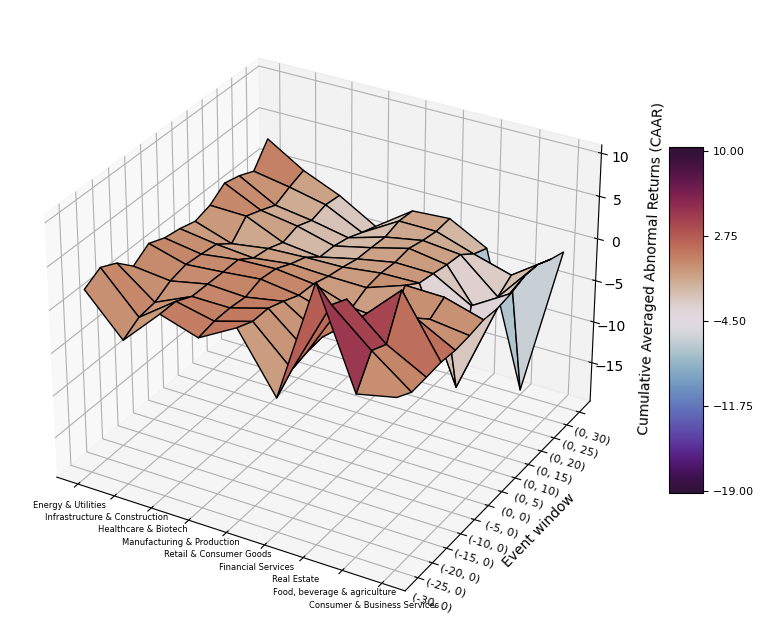

In [59]:
# Extract data
x = tabs_format1_clone.index

# Ensure x, y, and z are 2D grids for plot_surface
X, Y = np.meshgrid(range(len(sec_names)), range(len(x)))  # Numeric indices for plotting

# Retrieve Z values
Z = tabs_format1_clone.loc[:, (list(sec_names), 'CAAR')].values  # Transpose to match grid shapes


# Plotting
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')

# Create surface plot
surf = ax.plot_surface(X, Y, Z, cmap='twilight_shifted', edgecolor='k', vmin=np.min(Z), vmax=np.max(Z))

# Add a color bar
#fig.colorbar(surf, ax=ax)

cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.05)  # Customize shrink and aspect for better fit
cbar.set_ticks(np.linspace(-19, 10, num=5))  # Set ticks for the color bar
cbar.ax.tick_params(labelsize=8)

# Add labels
ax.set_ylabel('Event window')
#ax.set_ylabel('Sectors')
ax.set_zlabel('Cumulative Averaged Abnormal Returns (CAAR)')
#ax.set_title('3D Surface Plot from MultiIndex DataFrame')

ax.set_yticks(range(len(x)))
ax.set_yticklabels(x, rotation=-17, fontsize=8)  # X-axis uses DataFrame index values -17

#ax.set_xticks([i + 0.5 for i in range(len(sec_names))])
ax.set_xticks(range(len(sec_names)))
ax.set_xticklabels(list(sec_names), rotation=0, fontsize=6)  # Y-axis uses
#ax.set_zticklabels(np.round(np.arange(np.min(Z), np.max(Z), step=0.2), 2), fontsize=8)

ax.tick_params(axis='x',labelleft=True, pad=1)
ax.tick_params(axis='y', labelleft=True, pad=1)  # Y-axis ticks closer to the axis
ax.tick_params(axis='z', pad=0)
#fig.subplots_adjust(left=0.15, right=1)
#fig.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.3)
fig.savefig(r'C:\caocao\2023\NetZero\data v2.0\report_7\plots\v1_twilight_shifted.png', dpi=300)
plt.show()


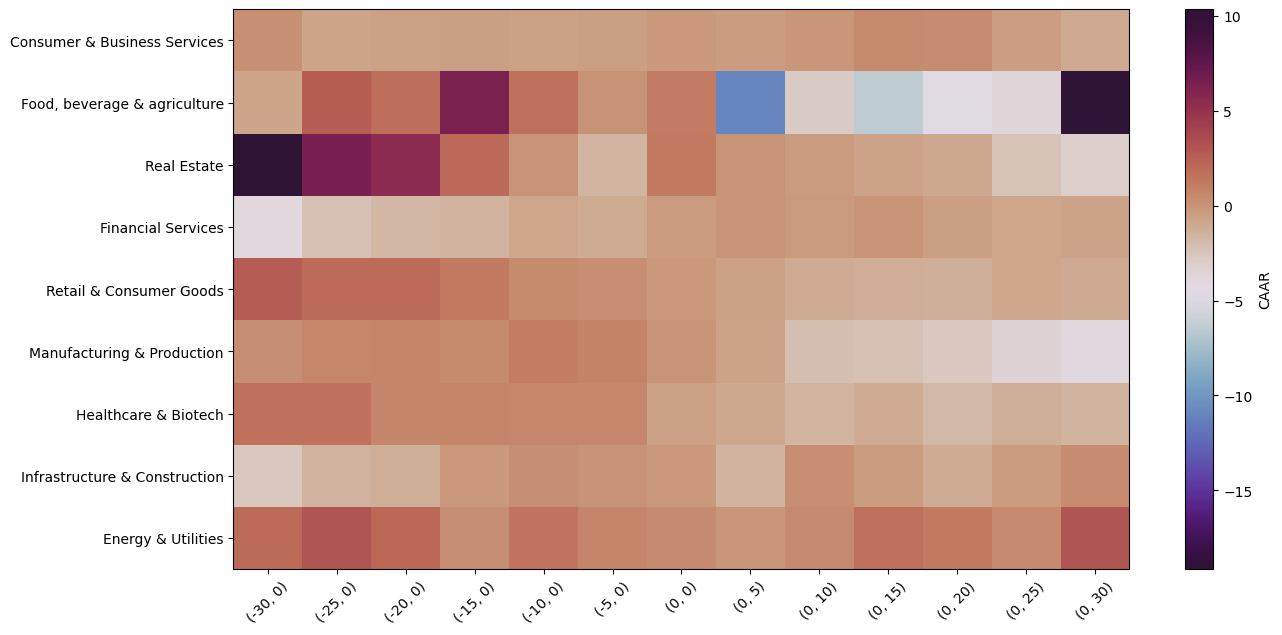

In [66]:
fig = plt.figure(figsize=(16, 8))
plt.pcolormesh(Y, X, Z, cmap='twilight_shifted', shading='auto')
plt.xticks(ticks=range(len(x)), labels=list(x), rotation=45)
plt.yticks(ticks=range(len(sec_names)), labels=sec_names, rotation=0)
plt.colorbar(label="CAAR")
#plt.title("2D Heatmap for Alignment Check")
fig.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2)
plt.show()
fig.savefig(r'C:\caocao\2023\NetZero\data v2.0\report_7\plots\2d.png', dpi=300)

In [26]:
tabs_format1_clone

Manufacturing & Production            \
                                        CAR   t value   
(Event window, )                                        
(-30, 0)                          -0.575666 -0.006203   
(-25, 0)                          -0.296141 -0.003480   
(-20, 0)                          -0.087690 -0.001159   
(-15, 0)                          -0.332222 -0.005058   
(-10, 0)                           0.445445  0.008215   
(-5, 0)                            0.466061  0.011723   
(0, 0)                            -0.161429 -0.010025   
(0, 5)                            -0.798108 -0.020235   
(0, 10)                           -2.327632 -0.043738   
(0, 15)                           -2.489946 -0.038794   
(0, 20)                           -3.042613 -0.041379   
(0, 25)                           -3.710507 -0.045513   
(0, 30)                           -4.406867 -0.049504   

                 Infrastructure & Construction           Real Estate  \
                                           CAR   t value         CAR   
(Event window, )                                                       
(-30, 0)                             -2.127453 -0.059448    9.915809   
(-25, 0)                             -1.925718 -0.059158    5.872447   
(-20, 0)                             -1.348902 -0.046333    5.283969   
(-15, 0)                             -0.252656 -0.010031    1.720444   
(-10, 0)                              0.514036  0.024712    0.194871   
(-5, 0)                               0.110857  0.007330   -0.882801   
(0, 0)                               -0.139916 -0.023431    1.312508   
(0, 5)                               -1.417012 -0.096878    0.538036   
(0, 10)                               0.340601  0.017198    0.227017   
(0, 15)                              -0.373747 -0.015648   -0.273517   
(0, 20)                              -1.426389 -0.052126   -0.554409   
(0, 25)                              -0.500628 -0.016442   -1.668350   
(0, 30)                               0.141036  0.004242   -2.349188   

                           Energy & Utilities           Healthcare & Biotech  \
                   t value                CAR   t value                  CAR   
(Event window, )                                                               
(-30, 0)          0.339375           0.181910  0.006565             1.369673   
(-25, 0)          0.215690           1.404320  0.055586             1.406699   
(-20, 0)          0.227330           1.056204  0.046423             0.819695   
(-15, 0)          0.089777          -0.683187 -0.034326             0.644562   
(-10, 0)          0.012311           0.953982  0.058153             0.431784   
(-5, 0)          -0.077139           0.807702  0.061568             0.522187   
(0, 0)            0.282600           0.250732  0.047039            -0.653633   
(0, 5)            0.047294          -0.434693 -0.033293            -0.998763   
(0, 10)           0.014738          -0.161948 -0.009161            -1.699314   
(0, 15)          -0.014723           0.573180  0.026883            -1.183162   
(0, 20)          -0.026049          -0.086220 -0.003530            -1.884106   
(0, 25)          -0.070448          -1.513958 -0.055702            -1.416146   
(0, 30)          -0.090846           0.907967  0.030594            -1.791058   

                           Financial Services            \
                   t value                CAR   t value   
(Event window, )                                          
(-30, 0)          0.035560          -3.748157 -0.050157   
(-25, 0)          0.040235          -2.108852 -0.031025   
(-20, 0)          0.026334          -1.624462 -0.026795   
(-15, 0)          0.023828          -1.406411 -0.026775   
(-10, 0)          0.019350          -0.807724 -0.018696   
(-5, 0)           0.031793          -1.127376 -0.035874   
(0, 0)           -0.101108          -0.290621 -0.023298   
(0, 5)           -0.063072           0.029515  0.000966   
(0, 10)          -0.0

**Radar chart**   
How many significant and non-significant in each sector?

In [132]:
radar_chart_info

{'Manufacturing & Production': {'Significant': 54, 'Non-significant': 817},
 'Infrastructure & Construction': {'Significant': 10, 'Non-significant': 133},
 'Real Estate': {'Significant': 1, 'Non-significant': 77},
 'Energy & Utilities': {'Significant': 7, 'Non-significant': 123},
 'Healthcare & Biotech': {'Significant': 20, 'Non-significant': 253},
 'Financial Services': {'Significant': 46, 'Non-significant': 669},
 'Retail & Consumer Goods': {'Significant': 19, 'Non-significant': 423},
 'Food, beverage & agriculture': {'Significant': 0, 'Non-significant': 13},
 'Consumer & Business Services': {'Significant': 54, 'Non-significant': 921}}

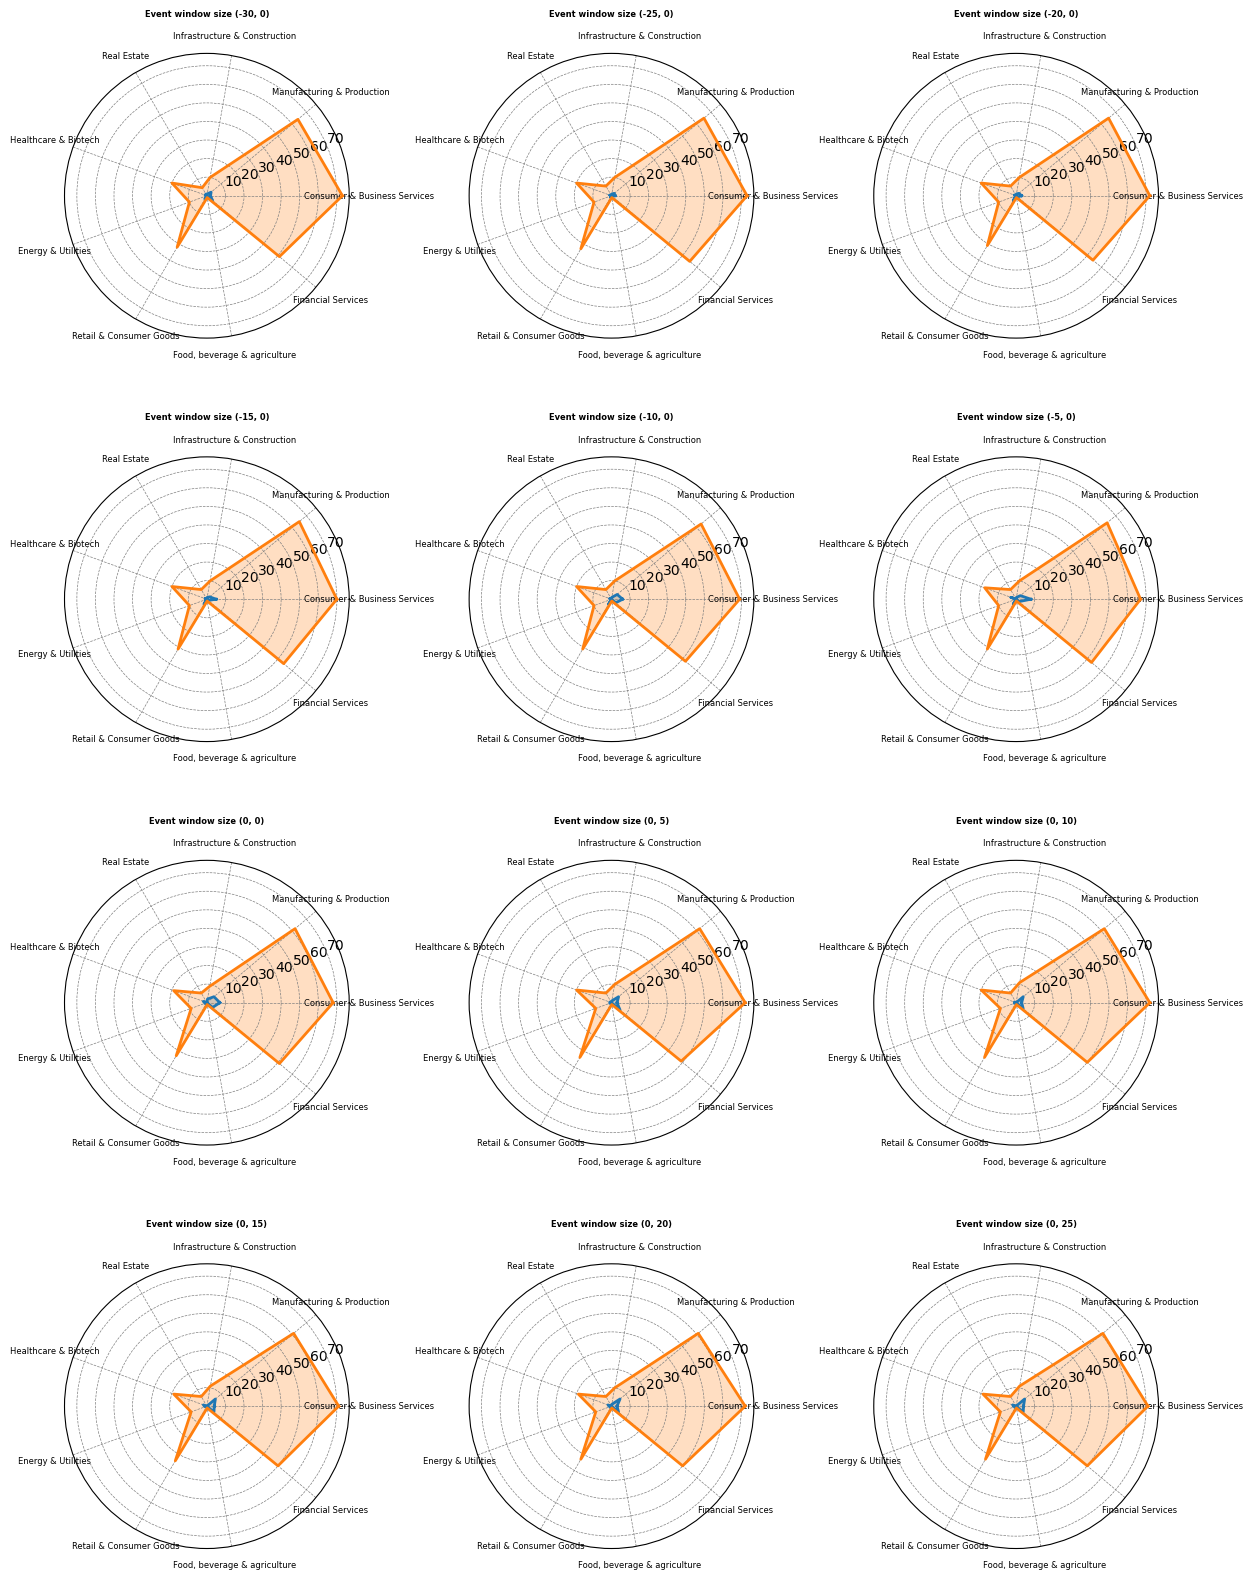

In [133]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 3, figsize=(12, 16), sharey=True, subplot_kw=dict(polar=True))
axs = axs.flatten()
for i, ax in enumerate(axs):
    radar_data = {}
    for sec in sec_names:
        radar_data[sec] = {'Significant':0, 'Non-significant':0}
    path = fr'C:\caocao\2023\NetZero\data v2.0\report_6\ver_{i+1}\logs.xlsx'
    log = pd.read_excel(path)
    for index, t_car in enumerate(log['t_car'].values):
        if abs(t_car)>=1.96:
            radar_data[log.iloc[index,1]]['Significant']+=1
        else:
            radar_data[log.iloc[index,1]]['Non-significant']+=1
# Data for the radar chart
# metrics = {
#     'Manufacturing & Production': {'Significant': 4, 'Non-significant': 3},
#     'Infrastructure & Construction': {'Significant': 1, 'Non-significant': 2},
#     'Real Estate': {'Significant': 2, 'Non-significant': 3},
#     'Energy & Utilities': {'Significant': 2, 'Non-significant': 5},
#     'Healthcare & Biotech': {'Significant': 2, 'Non-significant': 0}
# }
    metrics_df = pd.DataFrame(radar_data).T

    # Categories (A, B, C) and metrics (Positive, Negative, Zero)
    categories = metrics_df.index.tolist()
    num_vars = len(categories)

    # Angles for the radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the radar chart loop

    # Radar chart setup
    #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Plot each metric on the radar chart
    for label in metrics_df.columns:
        values = metrics_df[label].tolist()
        values += values[:1]  # Close the loop for each metric
        ax.plot(angles, values, label=label, linewidth=2, linestyle='solid')
        ax.fill(angles, values, alpha=0.25)

    # Customize the radar chart
    ax.set_xticks(angles[:-1])
    ax.set_title(f"Event window size {str(settings[i]['event window'])}", y=1.1, fontsize=6, fontweight="bold")
    #ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8)
    ax.grid(color='gray', linestyle='--', linewidth=0.5) 
    ax.set_xticklabels(categories, fontsize=6)
fig.tight_layout(pad=-1)
fig.savefig(r'C:\caocao\2023\NetZero\data v2.0\report_6\plots\radar.png', dpi=300)
plt.show()

**Bar chart**

In [11]:
dt = pd.read_excel(r'C:\caocao\2023\NetZero\data v2.0\report_7\countries_shink.xlsx', index_col=0)

In [12]:
dt

,Event window,Taiwan,Switzerland,Sweden,Denmark,China,Canada,Austria,Brazil,United States of America,...,United Kingdom,Saudi Arabia,Norway,Italy,Finland,South Korea,Japan,Germany,Malaysia,Thailand
0,"(-30, 0)",1.329313,4.897179,-2.415063,-4.975383,14.453630,4.899374,-12.947352,5.265099,-0.439778,...,-1.321654,0.746200,3.631562,3.983645,-1.541002,-7.884104,1.766915,-6.248068,4.773227,5.984951
1,"(-25, 0)",2.845434,2.840725,-1.521587,-2.629735,10.456545,5.008921,-9.449334,1.105810,0.188492,...,-1.764904,-0.815944,2.751844,6.417147,-3.157078,-2.217717,0.801513,-3.870686,-2.139162,-2.841201
2,"(-20, 0)",2.960822,1.131845,-1.013320,-4.606461,9.766691,4.918013,-7.228465,0.675574,0.261357,...,-0.549030,0.885053,-1.032262,4.056450,-1.952395,-0.026677,0.071081,-2.978812,-0.987881,2.536433
3,"(-15, 0)",0.221106,1.620567,-1.469821,-3.026718,3.947883,4.896769,-3.590553,-4.461724,0.157506,...,0.469284,6.534780,-0.139584,1.563399,5.993697,-2.444536,-1.014790,-1.913710,-2.340933,1.866188
4,"(-10, 0)",0.543877,1.739508,-0.984456,-1.190876,6.427871,4.351497,-2.893646,-2.645752,0.696414,...,0.112839,3.818261,2.957894,1.517895,0.908397,-5.532781,-1.132585,-0.001659,-0.610313,0.759443
5,"(-5, 0)",-1.514488,0.596830,-0.601635,-0.733605,2.260120,0.949082,0.349518,0.197938,0.469937,...,-0.168282,1.218962,0.809036,0.568328,1.927327,-3.562400,-1.156020,-0.260292,-1.054963,6.008512
6,"(0, 0)",-0.071560,-0.814769,-0.133711,-0.399852,1.966322,-0.153382,0.166189,0.566973,-0.371762,...,-0.317913,0.696180,0.197501,-0.466812,-0.116403,-2.148008,-0.172640,-0.225306,1.069820,1.285872
7,"(0, 5)",-3.060787,-3.548160,-1.593073,0.008364,-2.995085,0.084152,-0.614385,0.251572,-0.441905,...,-0.316283,-2.665653,2.152015,-2.475566,-0.707082,-4.345628,-0.543048,1.851879,-1.985197,1.219828
8,"(0, 10)",-6.836524,-3.289468,-2.383409,0.457178,-5.219441,-0.525387,1.135094,-1.676210,-0.137129,...,-1.074641,-3.218636,-0.437796,-1.405972,-3.349902,-3.430389,0.029461,0.920564,-6.456202,-5.602593
9,"(0, 15)",-7.263550,-3.989892,-1.437224,-1.604447,-0.433747,-1.393451,5.155838,-4.220333,0.173217,...,-0.458632,-4.739401,1.375307,-2.786731,-5.656497,-5.938968,-0.215793,3.018587,-3.904749,1.913810


In [54]:
dt[1:2].values[0][1:]

array([4.122277522936789, 4.935888895864406, 9.544444817836292,
       -14.50223583141715, 8.583171996029087, 2.72577853843022,
       -1.739631968692282, -1.100350031564495, -0.6340469913761618,
       -5.31861925846562, 2.010419185344038, 1.055552706410074,
       -0.3500911162793727, -1.849161790504136, -0.2398528033749127,
       -1.555001431908773, -9.989765413200288, -3.559870199751334,
       -1.223013404594661, 2.612189663986872, 0.4630098416131544,
       4.122495481843038, -2.012018606828105, -3.095229218270285,
       -6.388341604389784, -12.3327624472905, 3.003119633175612,
       -4.653673179890846, 0.4582241437235189], dtype=object)

In [59]:
dt['Event window']

0     (-30, 0)
1     (-25, 0)
2     (-20, 0)
3     (-15, 0)
4     (-10, 0)
5      (-5, 0)
6       (0, 0)
7       (0, 5)
8      (0, 10)
9      (0, 15)
10     (0, 20)
11     (0, 25)
12     (0, 30)
Name: Event window, dtype: object

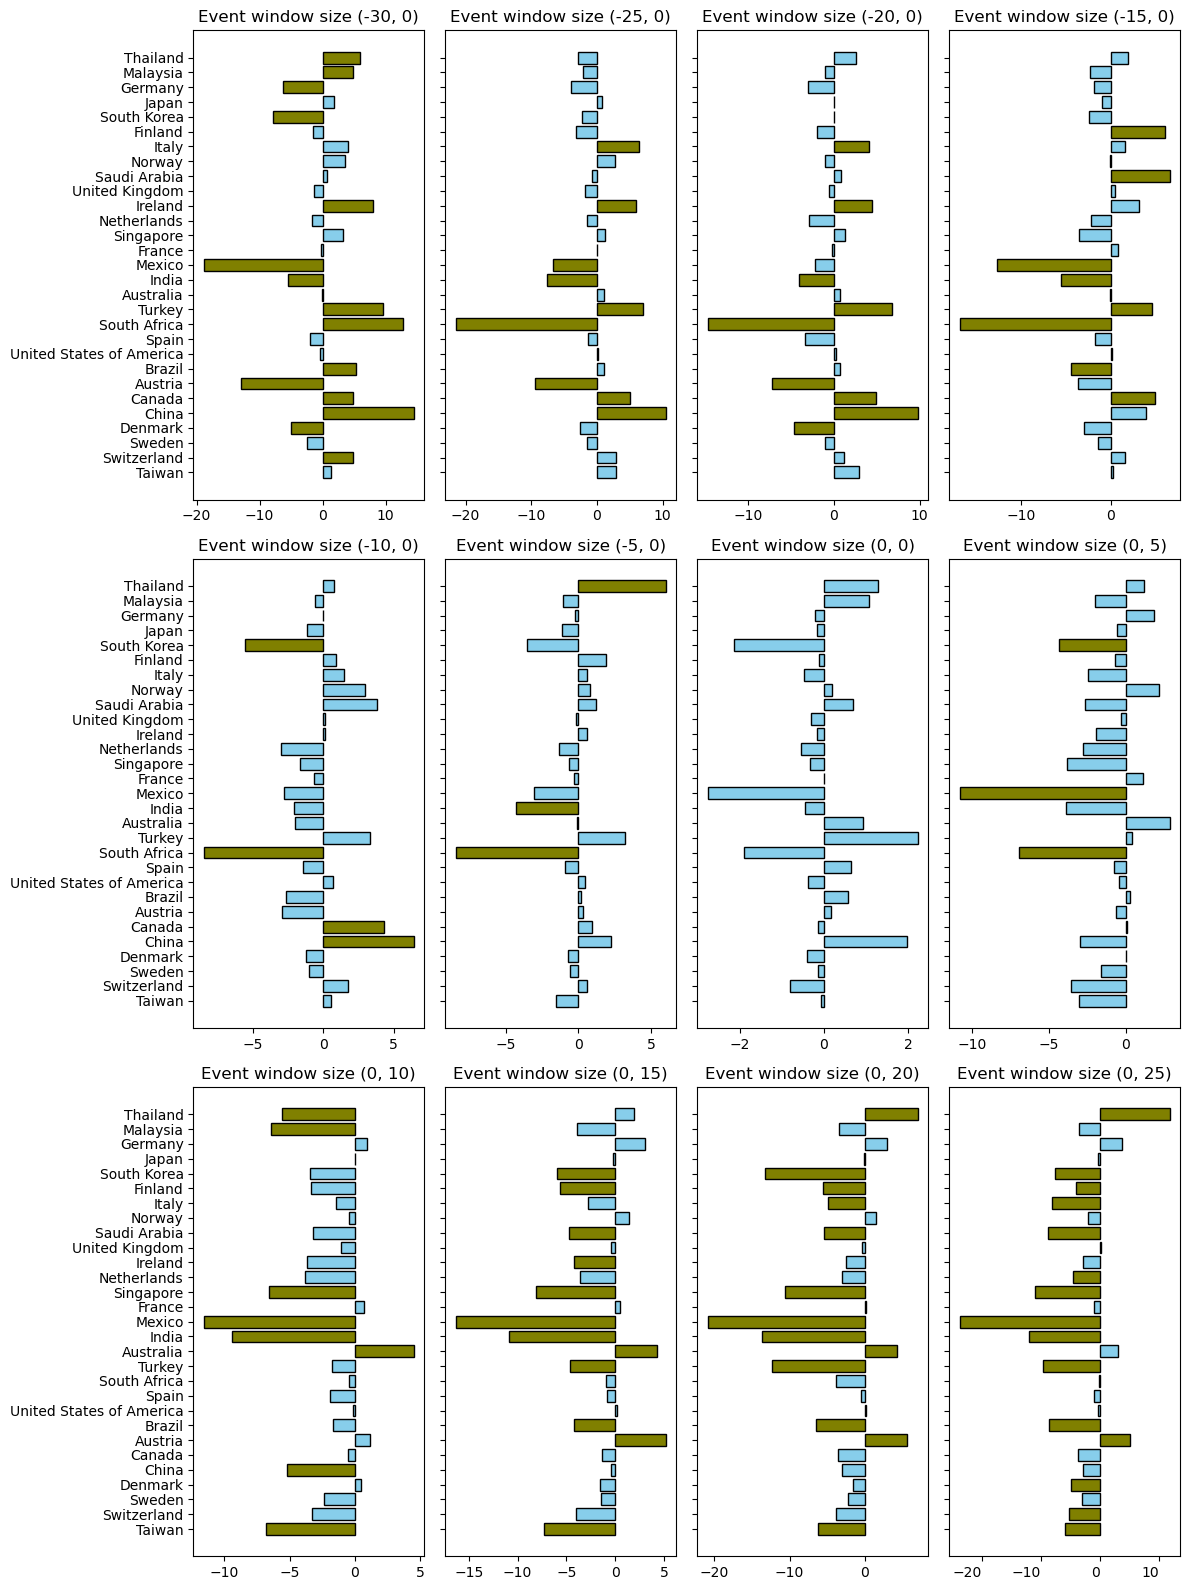

In [13]:
fig, axs = plt.subplots(3, 4, figsize=(12, 16), sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    colors = ['olive' if abs(value) >=4 else 'skyblue' for value in dt[i:i+1].values[0][1:]]
    ax.barh(dt.columns[1:], dt[i:i+1].values[0][1:], color=colors, edgecolor='black')
    ax.set_title(f'Event window size {dt["Event window"][i]}')

plt.xticks(fontsize=10, ha='right')
plt.yticks(fontsize=10, ha='right')

plt.tight_layout()
plt.savefig(r'C:\caocao\2023\NetZero\data v2.0\report_7\plots\bar_countries.png', dpi=300, bbox_inches='tight')
plt.show()

In [130]:
dt2 = pd.read_excel(r'C:\caocao\2023\NetZero\data v2.0\report_6\countries_shink2.xlsx', index_col=0)

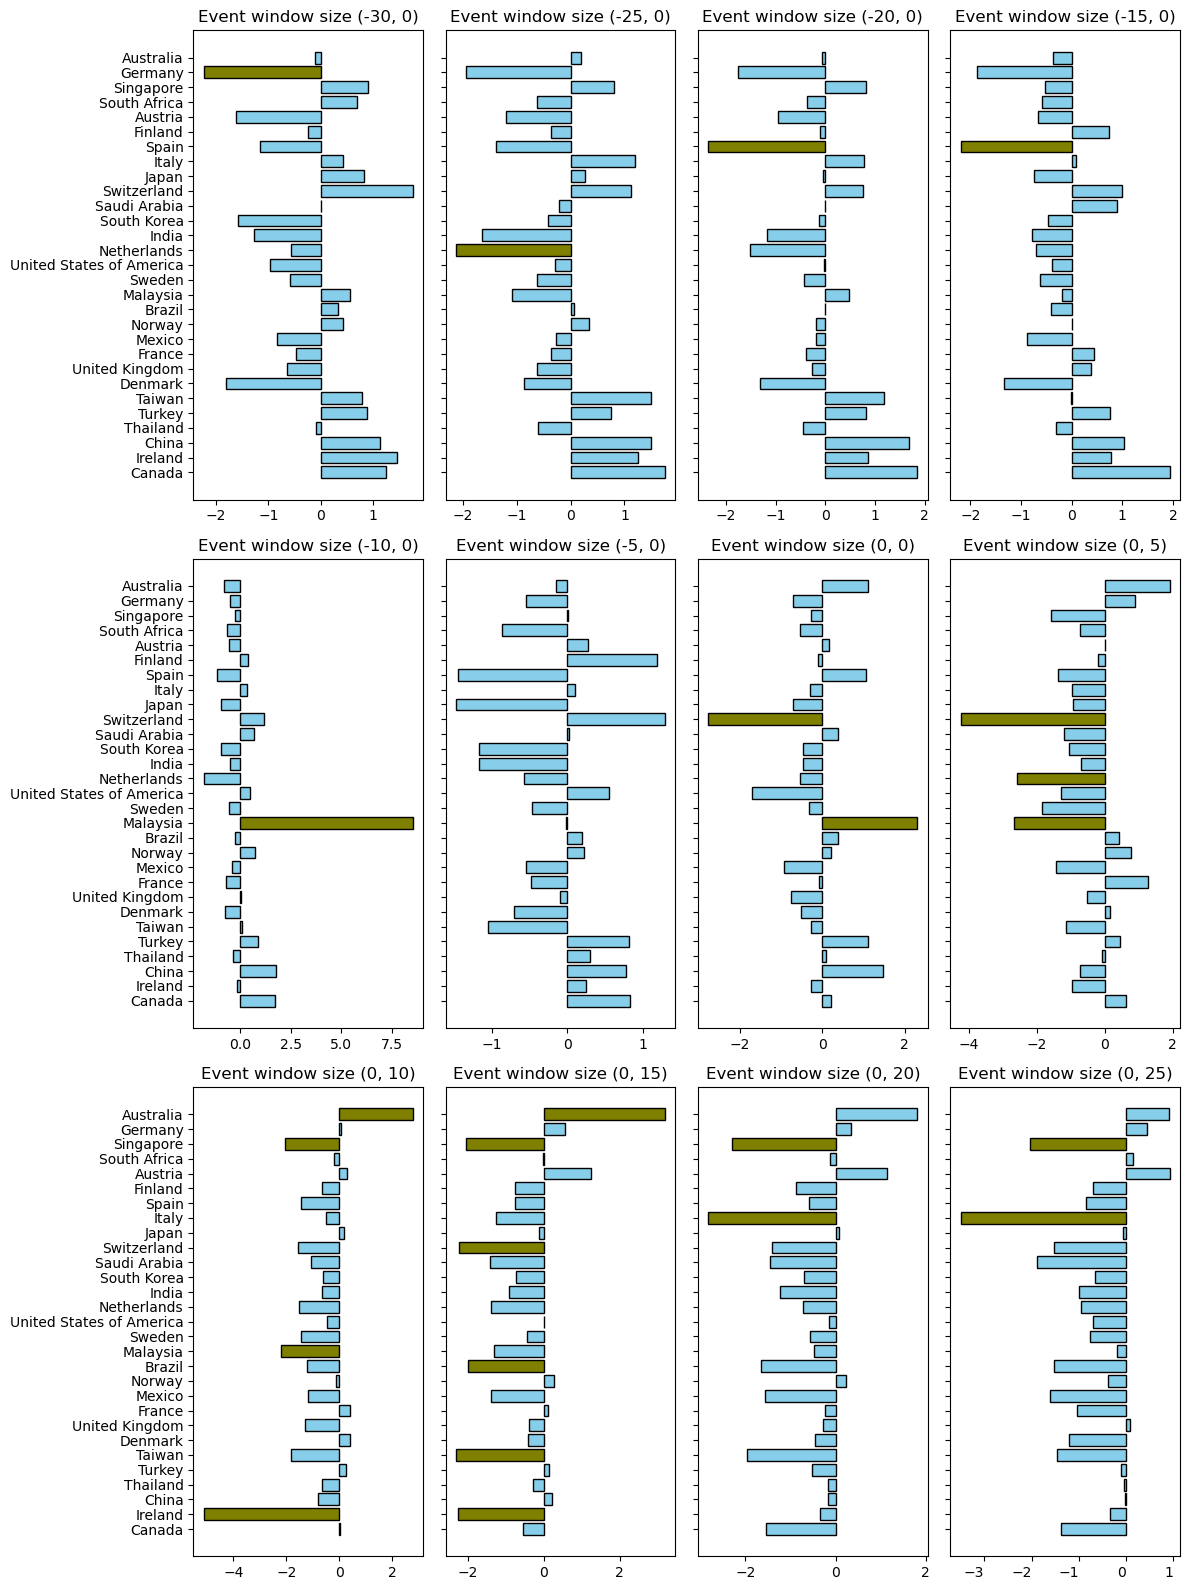

In [131]:
fig, axs = plt.subplots(3, 4, figsize=(12, 16), sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    colors = ['olive' if abs(value) >=1.96 else 'skyblue' for value in dt2[i:i+1].values[0][1:]]
    ax.barh(dt2.columns[1:], dt2[i:i+1].values[0][1:], color=colors, edgecolor='black')
    ax.set_title(f'Event window size {dt["Event window"][i]}')

plt.xticks(fontsize=10, ha='right')
plt.yticks(fontsize=10, ha='right')

plt.tight_layout()
plt.savefig(r'C:\caocao\2023\NetZero\data v2.0\report_6\plots\bar_countries_t_test.png', dpi=300, bbox_inches='tight')
plt.show()